# ITERATIVNE METODE ZA RJEŠAVANJE SUSTAVA LINEARNIH JENDADŽBI 

In [2]:
import math
import numpy as np

import scipy.sparse.linalg as spla
import scipy.linalg as la
import scipy as sp
import sympy as sym

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

**Uvodna napomena:** Za pokrenuti cijelu bilježnicu odjednom treba instalirati `ffmpeg` (za animacije) naredbom `conda install -c menpo ffmpeg` (Anaconda prompt za Windows, terminal za Linux). Ako instalacija ne uspije, pri kraju [koda](#asteroid) treba zakomentirati naznačenu liniju, budući da je animacija svakako uključena u `esej.rar`. Svi ostali paketi trebali bi biti uključeni uz zadnji update Anaconde 21.4.2020.

U ovom eseju ću predstaviti par metoda koje se koriste za rješavanje sustava linearnih jednadžbi ($n$ jednadžbi s $n$ nepoznanica). Upoznat ćemo se i s nekim primjerima iz primjene koji vode na sustav jednadžbi i pokušati, analizom reziduala u koracima metode, vizualizirati zašto je za neki sustav neka metoda bolja ili lošija. Vidjet ćemo u zadnjem primjeru, kao što se i moglo pretpostaviti, ovim algoritmima nije moguće riješiti svaki problem.  
1. [Uvod i motivacija](#uvod)
2. [Opis iterativnih metoda](#metode)
3. [Primjene](#primjene)
    1. [Električna mreža](#el.mreža)
    2. [Rješavanje Poissonove jednadžbe](#Poisson)
    3. [Orbita asteroida](#asteroid)
4. [Zaključak](#zaključak)

<a id='uvod'></a> 
## 1. Uvod i motivacija


U stvarnim primjenama sustavi jednadžbi mogu biti znatno većih dimenzija od $2x2$ ili $3x3$. Ako znamo da je za realizaciju Gaussovih eliminacija potrebno $\mathcal{O}(n^3)$ operacija, onda to predstavlja opterećenje za rješavanje problema reda npr. $n=10^4$ budući da računalo ima ograničenja na numeričku točnost, raspoloživi memorijski prostor i vrijeme izvršavanja. Međutim, mnoge primjene vode na rješavanje sustava jednadžbi gdje matrica sustava $A$ ima specifičan oblik ili svojstva pa možemo pokušati s drugačijim algoritmima. Recimo, matrica sustava koja proizlazi iz diskretizacije problema rješavanja [Poissonove jednadžbe](#Poisson) na pravokutnoj domeni ima oblik blok-TST matrice(T:(Toeplitzova) konstantna duž dijagonala, S: simetrična, T:tridijagonalna). 

<a id='metode'></a> 
## 2. Iterativne metode

Iterativna metoda je ona koja uzima neki početnu iteraciju (*initial guess*) i generira niz 'sve boljih' aproksimativnih rješenja, a u svakom koraku koristi aproksimaciju prethodnog koraka. Sjetimo se recimo [Newtonove metode](https://en.wikipedia.org/wiki/Newton%27s_method) za nalaženje rješenja nelinearne jednadžbe $f(x)=0$. Uz neke pretpostavke na funkciju $f$ algoritam je bio: 

$$x^{(n+1)}=x^{(n)}-\dfrac{f(x^{(n)})}{f'(x^{(n)})}$$ 

Mi želimo naći rješenje sustava $Ax=b$, tj. njegovu aproksimaciju $\tilde{x}$. Za mjerenje koliko je aproksimacija dobra definiramo rezidual $r=b-A\tilde{x}$ i uzimamo $\tilde{x}$ kao *dovoljno dobro rješenje* ako je $\epsilon=\dfrac{ \lVert r \rVert}{\lVert b \rVert} $ manji od neke unaprijed zadane tolerancije. Upravo ćemo taj $\epsilon$ uzeti za uvjet zaustavljanja u metodama koje ćemo koristiti. 

Napišimo matricu sustava kao $A=M-N$ gdje je $M$ regularna matrica i $M^{-1}A\approx I$. Uvrstimo li to u polazni sustav, dobivamo: 

$$Mx=Nx+b,\:\:tj.\:\:x=M^{-1}Nx+M^{-1}b$$

Označimo li sa $F=M^{-1}N$ i $c=M^{-1}b$, imamo $x=Fx+c$ pa možemo pokušati s iteracijama oblika:

$$x^{(k+1)}=Fx^{(k)}+c$$ 

Matricu $F$ zovemo matrica iteracije i (uz $c$) definira metodu. Postavlja se pitanje hoćemo li doći do približnog rješenja, tj. kako odabrati rastav matrice $A=M-N$ da algoritam konvergira k rješenju. 

U tome se razlikuju iterativne metode koje ćemo promatrati u ovom eseju i za svaku od njih je navedeno kako djeluju na koordinate vektora (radi jednostavnosti dimenzija će biti $n=3$), a algoritam će biti proveden za proizvoljnu dimenziju. Za više informacija o implementaciji pogledati konkretan kod. 

### Jacobijeva metoda

$M=diag(A)$, tj. samo dijagonala od $A$, pa je $N=M-A$, tj. vandijagonalni dio od $-A$.


Pogledajmo radi jednostavnosti kako izgledaju te iteracije na sustavu reda $n=3$. Vektor nepoznanica je $x=(x_1,x_2,x_3)$:
$$x_{1}^{(k+1)}=\dfrac{1}{a_{11}}(b_{1}-a_{1,2}x_{2}^{(k)}-a_{1,3}x_{3}^{(k)})$$
$$x_{2}^{(k+1)}=\dfrac{1}{a_{22}}(b_{2}-a_{2,1}x_{1}^{(k)}-a_{2,3}x_{3}^{(k)})$$
$$x_{3}^{(k+1)}=\dfrac{1}{a_{33}}(b_{3}-a_{3,1}x_{1}^{(k)}-a_{3,2}x_{2}^{(k)})$$

Dakle, generiramo vektor $x^{(k+1)}$ pomoću vektora $x^{(k)}$ sve dok dvije uzastopne iteracije ne budu jednake do na neku znamenku (tj. unaprijed zadanu točnost) i pri tome ne mijenjamo elemente matrice $A$.
Iz prethodnog algoritma vidimo da je ova metoda dobro definirana samo za matrice $A$ za koje je $a_{ii}\neq0,\:i=1,...,n$. Ako naiđemo na dijagonalni element takav da $a_{ii}=0$, treba probati mijenjanjem poretka jednadžbi svesti sustav na pogodan oblik.
Zadavanjem početne iteracije $x_0$, možemo krenuti s testiranjem metode. 

In [3]:
def jacobi(A, b, *args, **kwargs):
    
    """
    Jacobijeva metoda rješava sustav Ax = b. 
    
    ~~~ Ulaz ~~~
    
    A : [matrica; !] poželjno strogo dijagonalno dominantna ili ireducibilno 
        dijagonalno matrica sustava 
    b : [vektor; !] desna strana sustava
    
    *args: 
        x0 : [vektor] prva iteracija; po defaultu x0 nul vektor
    
    **kwargs: 
        tol : [skalar] zadana tolerancija za konvergenciju; po defaultu 1e-9
        maxit : [skalar] maksimalni broj iteracija; po defaultu 1000
    
    ~~~ Izlaz ~~~
    
    x : [vektor] aproksimativno rješenje
    res : [vektor] vektor reziduala u k-tom koraku metode ||Ax-b||/||b||
    info : [bool] daje informaciju o konvergenciji ka rješenju
           >> info = True : metoda je konvergirala 
           >> info = False : metoda nije konvergirala
    """
 
    if len(args) > 0:
        x0 = np.array([])
        for arg in args: 
            x0 = np.append(x0, arg) 
    else:
        x0 = np.zeros(len(b))
 
    maxit = 1000
    tol = 1e-9
    for key, value in kwargs.items():
        if key == 'tol':
            tol = value
        if key == 'maxit':
            maxit = value
        
    res = np.array( [] )
    p = x0
    nrb = la.norm(b)
    for k in range( maxit ):
        for i in range( len(b) ):
            x0[i] = ( b[i] - ( np.dot( A[i,:], p ) - A[(i,i)]*p[i] ) ) / A[(i,i)]
        p = x0
        res = np.append( res, la.norm( np.dot(A,x0) - b )/nrb )
        if res[k] < tol:
            info = True
            return p, res, info 
    info = False
    
    return x0, res, info

In [4]:
# PRIMJER
A = np.array([[5, 0.2, 0.3], [0.5, 10, 0.3], [0.1, 0.2, 15]])
A = A - np.eye(3)

b = np.array([-20, -10, -30])
x, res, info = jacobi(A,b,np.ones(3), tol=1.0e-9)
if info == False:
    print('Metoda nije konvergirala!\n')
else: 
    xp = la.solve(A,b)
    print('Rezultat')
    print(x)
    rezultati = pd.DataFrame( [[max(abs(x-xp)), la.norm(x-xp), len(res), 1e-9, info] ], columns=['norma $\infty$ vektora greške','2 norma vektora greške','broj iteracija','tolerancija','konvergencija'], index=['Jacobi'])
    display(rezultati)

Rezultat
[-4.8039735  -0.77430764 -2.09748151]


,norma $\infty$ vektora greške,2 norma vektora greške,broj iteracija,tolerancija,konvergencija
Jacobi,1.402336e-10,1.409921e-10,5,1.000000e-09,True


Za početnu iteraciju uzeli smo $x_0=[1,1,1]$. Iz norme vektora greške $e=x-x_p$ vidimo da se rješenje $x$ dobiveno algoritmom ne razlikuje puno od rješenja $x_p$ dobivenog sa `scipy.linalg.solve()`.

### Gauss-Seidelova metoda 
Promatranjem prethodnog algoritma vidimo da u $k+1$ koraku, pri generiranju $x_i^{(k+1)}$ koordinate, možemo koristiti informaciju od $x_{i-1}^{(k+1)}$ budući da očekujemo da iteracije konvergiraju. 

Pa se algoritam za sustav reda $n=3$ svodi na:
$$x_{1}^{(k+1)}=\dfrac{1}{a_{11}}(b_{1}-a_{1,2}x_{2}^{(k)}-a_{1,3}x_{3}^{(k)})$$
$$x_{2}^{(k+1)}=\dfrac{1}{a_{22}}(b_{2}-a_{2,1}x_{1}^{(k+1)}-a_{2,3}x_{3}^{(k)})$$
$$x_{3}^{(k+1)}=\dfrac{1}{a_{33}}(b_{3}-a_{3,1}x_{1}^{(k+1)}-a_{3,2}x_{2}^{(k+1)})$$


### SOR metoda

U Gauss-Seidelovu metodu uvodimo realni parametar $\omega$ kako bismo pokušali ubrzati konvergenciju. Primijetimo da uvrštavanjem $\omega=1$ dobivamo Gauss-Seidelovu metodu pa nema potrebe da pišemo dupli kod, samo pošaljemo dodatni argument `omega=1`.

$$x_{1}^{(k+1)}=(1-\omega)x_{1}^{k}+\dfrac{\omega}{a_{11}}(b_{1}-a_{1,2}x_{2}^{(k)}-a_{1,3}x_{3}^{(k)})$$
$$x_{2}^{(k+1)}=(1-\omega)x_{2}^{k}+\dfrac{\omega}{a_{22}}(b_{2}-a_{2,1}x_{1}^{(k)}-a_{2,3}x_{3}^{(k)})$$
$$x_{3}^{(k+1)}=(1-\omega)x_{3}^{k}+\dfrac{\omega}{a_{33}}(b_{3}-a_{3,1}x_{1}^{(k)}-a_{3,2}x_{2}^{(k)})$$

Do optimalnog parametra $\omega$ dolazimo 'eksperimentalno'. Točnije, funkcija `sor_konvergencija` računa kakav $\omega$ treba uzeti da algoritam završi sa što manje iteracija. 

In [5]:
def sor_konvergencija(A):
    omega = np.linspace(0,2,201)
    rho = np.zeros(201)
    D = np.diag(np.diag(A))
    R = np.triu(A,1)
    L = np.tril(A,-1)
    
    for i in range(len(omega)):    
        T = la.inv(D + omega[i]*L)@((1-omega[i])*D-omega[i]*R)
        v, u = la.eig(T)
        rho[i] = max(abs(v))
    return omega, rho

def sor(A, b, *args, **kwargs):
    
    """
    SOR metoda računa optimalni omega pozivanjem funkcije sor_konvergencija 
    i rješava sustav Ax = b. 
    
    ~~~ Ulaz ~~~
    
    A : [matrica; !] poželjno strogo dijagonalno dominantna ili ireducibilno
        dijagonalno dominantna
    b : [vektor; !] desna strana sustava
    
    *args:
        x0 : [vektor] prva iteracija; po defaultu x0 nul vektor
    
    **kwargs:
        tol : [skalar] zadana tolerancija za konvergenciju; po defaultu 1e-9 
        maxit : [skalar] maksimalni broj iteracija; po defaultu 1000
    
    ~~~ Izlaz ~~~
    
    x : [vektor] aproksimativno rješenje
    res : [vektor] vektor reziduala u k-tom koraku metode
    info : [bool] daje informaciju o konvergenciji ka rješenju
           >> info = True : metoda je konvergirala 
           >> info = False : metoda nije konvergirala
    """

    if len(args) > 0:
        x0 = np.array([])
        for arg in args: 
            x0 = np.append(x0, arg) 
    else:
        x0 = np.zeros(len(b))
 
    maxit = 1000
    tol = 1e-9
    omega_niz, rho = sor_konvergencija(A)
    omega = omega_niz[np.argmin(rho)]
    for key, value in kwargs.items():
        if key == 'tol':
            tol = value
        if key == 'maxit':
            maxit = value
        if key == 'omega':
            omega = value
    

    res = np.array( [] )
    p = x0
    nrb = la.norm(b)
    for k in range( maxit ):
        for i in range( len(b) ):
            x0[i] = x0[i] + omega*( b[i] - np.dot( A[i,:], x0 ) ) / A[(i,i)]
        p = x0
        res = np.append( res, la.norm( np.dot(A,x0) - b )/nrb )
        if res[k] < tol:
            info = True
            return p, res, info 
    info = False
    return p, res, info


Rješavamo jedan primjer metodom SOR. Na slici je graf spektralnih normi, a funkcija `sor_konvergencija` će za optimalni $\omega$ vratiti minimum vrijednosti, tj. ovdje otprilike $\omega=1.05$

Rezultat
[1. 1. 1. 1.]


,norma $\infty$ greške,2 norma greške,broj iteracija,tolerancija,konvergencija
SOR,4.813927e-13,5.304900e-13,13,1.000000e-09,True


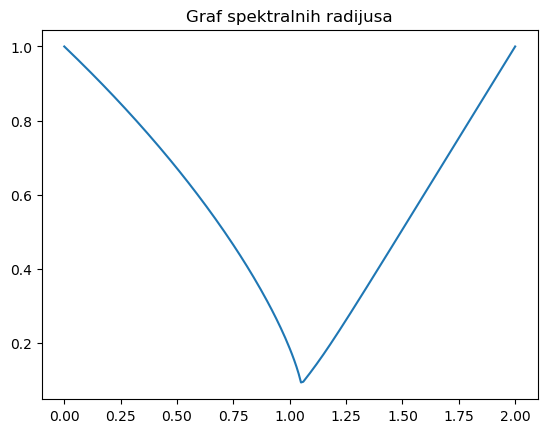

In [23]:
# PRIMJER
A1 = np.array( [ [101, -4, 8, 12], [-4, 20, -7, 3], [8, -7, 78, 32], [12, 3, 32, 113] ] )
b1 = np.array( [117, 12, 111, 160] )
sor_konvergencija(A1)
x, res, info = sor( A1, b1, np.zeros(4), tol=1e-12 )


# usporedba sa Python rutinom
xp = la.solve(A1,b1)

pd.set_option('display.width', 10000)
if info == False:
    print('Metoda nije konvergirala!\n')
else: 
    xp = la.solve(A1, b1)
    print('Rezultat')
    print(x)
    rezultati = pd.DataFrame( [[max(abs(x-xp)), la.norm(x-xp), len(res), 1e-9, info] ], columns=['norma $\infty$ greške','2 norma greške','broj iteracija','tolerancija','konvergencija'], index=['SOR'])
    #pd.set_option('display.max_colwidth', None)
    display(rezultati)

mpl.rcParams.update(mpl.rcParamsDefault)    
omega, rho = sor_konvergencija(A1)
fig, ax = plt.subplots()
ax.set_title('Graf spektralnih radijusa')
ax.plot(omega, rho)
plt.show()


<a id='primjene'></a> 
## 3. Primjeri iz primjene

Prava korist razlikovanja prethodnih metoda dolazi do izražaja kada se uspoređuju na istim problemima.

<a id='el.mreža'></a> 
### 3.1. Električna mreža 
Računamo potencijal u električnoj mreži na slici. 

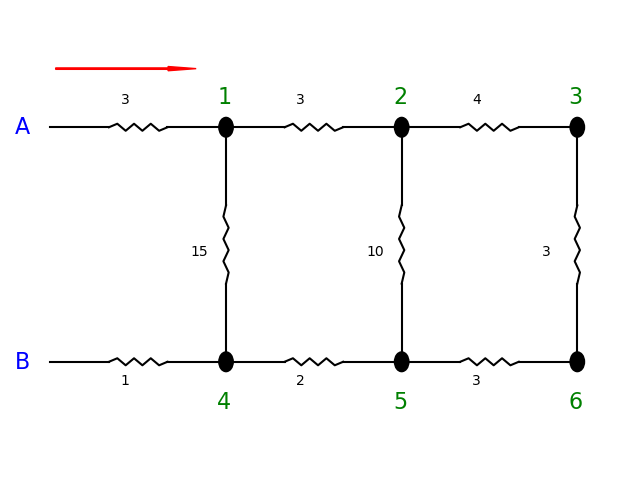

In [7]:
#%matplotlib agg
from matplotlib.patches import Circle
from matplotlib.patches import Arrow
fig3, ax3 = plt.subplots()

smjer = Arrow(0.03,2.25,0.8,0,ec='red',fc='red',width=0.03)
ax3.add_patch(smjer)

fig3.set_size_inches(8,6)
def horizontalno(i,j):
    ax3.plot([i, i+1/3],[j, j],'k',[i+2/3,i+1],[j, j],'k')
    x = np.linspace(i+1/3,i+2/3,8)
    y = j*np.ones(8) + np.array([0,0.015,-0.015,0.015,-0.015,0.015,-0.015,0])
    ax3.plot(x,y,'k')
    
def vertikalno(i,j):
    ax3.plot([i, i],[j, j+1/3],'k',[i, i],[j+2/3,j+1],'k')
    y = np.linspace(j+1/3,j+2/3,8)
    x = i*np.ones(8) + np.array([0,0.015,-0.015,0.015,-0.015,0.015,-0.015,0])
    ax3.plot(x,y,'k')
for i in range(3):
    horizontalno(i,1)
    horizontalno(i,2)
for i in range(3):
    vertikalno(i+1,1)
    
for i in range(3):
    ax3.text(i+0.95,2.1,i+1,color='g',fontsize=16)
    patch = Circle((i+1,1),0.045,fc='k')
    ax3.add_patch(patch)

for i in range(3):
    ax3.text(i+0.95,0.8,i+4,color='g',fontsize=16)
    patch = Circle((i+1,2),0.045,fc='k')
    ax3.add_patch(patch)
    
otpori =np.array([[3,3,4],[15,10,3],[1,2,3]])
for i in range(3):
    ax3.text(i+0.4,0.9,otpori[(2,i)])
for i in range(3):
    ax3.text(i+0.4,2.1,otpori[(0,i)])
for i in range(3):
    ax3.text(i+0.8,1.45,otpori[(1,i)])

ax3.text(-0.2,0.97,'B',color='b',fontsize=16)
ax3.text(-0.2,1.97,'A',color='b',fontsize=16)
ax3.set_xlim(-0.23,3.3)
ax3.set_ylim(0.53,2.5)

plt.axis('off')
plt.close(fig3)
fig3

Otpori u otporicima su dani na slici, a razlika potencijala između točaka $A$ i $B$ je $100\;V$. Iz Ohmovog zakona slijedi da je jakost struje $I_{PQ}$ između točaka $P$ i $Q$ (smjer $P\rightarrow Q$) dana sa: $$I_{PQ}=\dfrac{v_P-v_Q}{R_{PQ}}$$ gdje su $v_P$ i $v_Q$ potencijali u točkama $P$ i $Q$, a $R_{P,Q}$ je otpor grane $PQ$. Prema Kirchoffovom zakonu, suma jakosti struja koje završavaju u jednom čvoru moja biti jednaka $0$. Na gornjoj slici (smjer struje naznačen je crvenom strelicom) za čvor $1$ to znači: 

$$0=I_{A1}-I_{12}-I_{16}=\dfrac{100-v_1}{3}+\dfrac{v_2-v_1}{3}+\dfrac{v_6-v_1}{15}$$ 

$$11v_1-5v_2-v_6=500$$

Prethodni postupak možemo provesti za svaki od 6 čvorova i na kraju dobivamo sustav 6 jednadžbi sa 6 nepoznanica. 

$$Av=b$$

In [8]:
A = np.array([[11,-5,0,0,0,-1],[-20,41,-15,0,-6,0],[0,-3,7,-4,0,0],[0,0,-1,2,-1,0],[0,-3,0,-10,28,-15],[-2,0,0,0,-15,47]])
b = np.array([500,0,0,0,0,0])

v1, res1, info1 = sor( A, b , tol = 1e-9)
v2, res2, info2 = sor( A, b, omega = 1, tol = 1e-9)
if info1 == True & info2 == True:
    print('rješenje v')
    print(v1)
    rezultati = pd.DataFrame( [[info1, len(res1)],[info2, len(res2)]], columns=['konvergencija','broj iteracija'], index=['SOR','Gauss-Seidel'])
    display(rezultati)
else:
    print('Metode nisu konvergirale!')

rješenje v
[69.99999998 51.99999997 39.99999997 30.99999999 21.99999999 10.        ]


,konvergencija,broj iteracija
SOR,True,25
Gauss-Seidel,True,73


U gornjoj tablici je vidljivo da je SOR metodi bilo potrebno manje iteracija da dođe do rješenja. Sličnu priču možemo vidjeti i na sljedećem grafu koji prikazuje kako opada vrijednost $\dfrac{||r||}{||b||}$, gdje je $r=Ax-b$. 

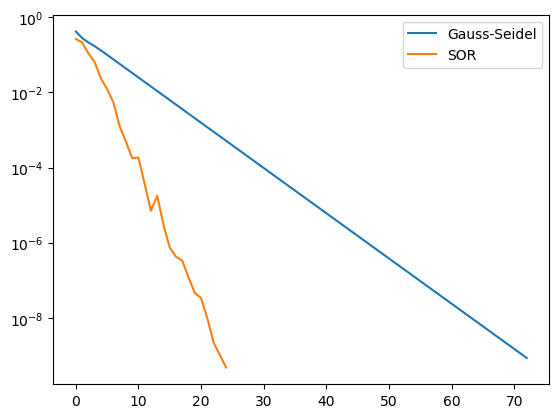

In [9]:
plt.semilogy(res2,label='Gauss-Seidel')
plt.semilogy(res1,label='SOR')
plt.legend()
plt.show()

<a id='Poisson'></a> 
### 3.2. Poissonova jednadžba na jediničnom kvadratu

Imamo sljedeći rubni problem: 

$$\Delta u(x,y)=f(x,y)\:\:na\;\Omega$$ $$u(x,y)=0\:\:na\; Fr(\Omega)$$

gdje je $\Omega$ unutrašnjost jediničnog kvadrata, a $Fr(\Omega)$ rub kvadrata. $\Delta$ je Laplaceov operator, tj. gore zapravo piše: 

$$\frac{{\partial}^2 u}{\partial x^2}+\frac{{\partial}^2 u}{\partial y^2}=f(x,y)\:\:na\;\Omega$$ 
$$u(x,y)=0\:\:na\; Fr(\Omega)$$. Na domeni na kojoj rješavamo zadani problem uvodimo uniformnu mrežu: 

$$\{x_i,y_i\::\;i=0,1,...,n_x+1,\:j=0,1,...,n_y+1\}$$

sa koracima: $$h_x=\dfrac{1}{n_x+1}\;h_y=\dfrac{1}{n_y+1}$$
Tada je $$x_0=0\;\;x_{n_x+1}=1\;\;x_i=ih_x\;\;i=1,...,n_x$$
$$y_0=0\;\;y_{n_y+1}=1\;\;y_i=ih_y\;\;j=1,...,n_y$$

Pogledajmo sljedeću sliku za ilustraciju ove mreže.

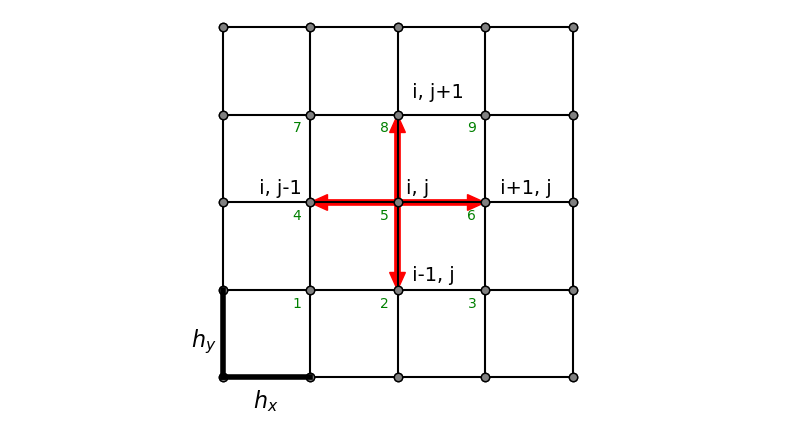

In [12]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)


fig2, ax2 = plt.subplots()
fig2.set_size_inches(10, 5)

for i in range(5):
    ax2.plot(np.linspace(0,4,5),i*np.ones(5),'-ok',markerfacecolor='grey',markeredgecolor='k')
for i in range(5):
    ax2.plot(i*np.ones(5),np.linspace(0,4,5),'-ok',markerfacecolor='grey',markeredgecolor='k')

str = [[' i, j+1',(2.1,3.2)],[' i, j-1',(0.35,2.1)],[' i+1, j',(3.1,2.1)],[' i-1, j',(2.1,1.1)]]
for x,y in str:
    ax2.annotate(x,y,fontsize=14)

ax2.annotate('i, j',(2.1,2.1),fontsize=14)

pos = [[1,0],[0,1],[-1,0],[0,-1]]
for x in pos:
    strelica = Arrow(2,2,x[0],x[1],ec='red',fc='red',width=0.3)
    ax2.add_patch(strelica)


ax2.plot([0, 1], [0, 0], color='k',lw=4)
ax2.plot([0, 0], [0, 1], color='k',lw=4)
ax2.text(0.35, -0.35, '$h_{x}$',fontsize=16)
ax2.text(-0.36, 0.35, '$h_{y}$',fontsize=16)

# numeriranje čvorova
k = 1
for j in range(3):
    for i in range(3):
        ax2.text(0.8+i,j+0.8,k,color='g')
        k = k+1
ax2.axis('equal')
ax2.axis('off')
plt.close(fig2)
fig2

Aproksimiramo i druge dervacije centralnim diferencijama:

$$u_{i,j}\approx u(x_i,y_j)$$
$$\frac{{\partial}^2 u(x_i,y_j)}{\partial x^2}\approx\dfrac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{h_x^2}$$
$$\frac{{\partial}^2 u(x_i,y_j)}{\partial y^2}\approx\dfrac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{h_y^2}$$

Pa problem $\Delta u(x,y)=f(x,y)$ postaje:
$$\dfrac{-u_{i-1,j}+2u_{i,j}-u_{i+1,j}}{h_x^2}+\dfrac{-u_{i,j-1}+2u_{i,j}-u_{i,j+1}}{h_y^2}=f_{i,j}$$ za $i=1,...,n_x$, $j=1,...,n_y$ uz $f_{i,j}=f(x_i,y_j)$. 

Na rubu kvadrata imamo rubni uvjet s početka problema, odnosno tu rješenje mora biti 0 pa za čvorove koji su na rubu vrijedi sljedeće: $$u_{0,j}=u_{n_x+1,j}=0\;,\;j=0,...,n_y+1$$ $$u_{i,0}=u_{i,n_j+1}=0\;,\;i=0,...,n_x+1$$

Vektor nepoznanica je $$u=[u_{1,1},...,u_{n_x,1},u_{1,2},...,u_{n_x,n_y-1},u_{1,n_y},...,u_{n_x,n_y}]$$
a vektor desne strane sustava $$b=[f_{1,1},...,f_{n_x,1},f_{1,2},...,f_{n_x,n_y-1},f_{1,n_y},...,f_{n_x,n_y}]$$

Time smo dobili sustav $$Au=b$$

Na prethodnoj slici vidimo da smo numerirali čvorove počevši od pozicije $(1,1)$ i završavajući na $(7,3)$, ali mogli smo i bilo kojim drugim poretkom. Bitno je jedino da tada vektor nepoznanica interpretiramo točno. 

Probajmo sada taj problem riješiti na jediničnom kvadratu $[0,1]$x$[0,1]$. Uzimamo ekvidistantnu subdiviziju, tj. $n_{x}=n_{y}=9$, pa je tada $h_{x}=h_{y}=0.1$ i funkciju $$f(x,y)=0\;\;za\;\;(x,y)\neq{(0,0)}$$ $$f(x,y)=10000\;\;za\;\;(x,y)=(0,0)$$. Problem je reda $n=81x81$

Raspored netrivijalnih elemenata matrice sustava A


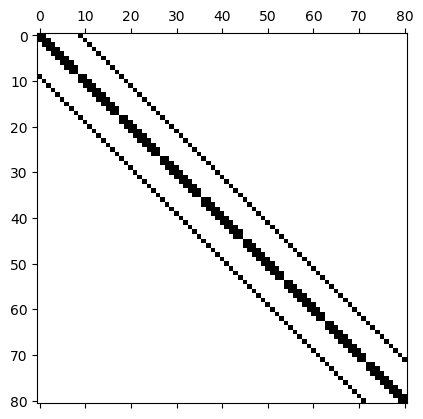

,konvergencija,broj iteracija
SOR,True,36
Gauss-Seidel,True,192


In [13]:
A = 4*np.eye(81) - np.diag(np.ones(81-1), -1) - np.diag(np.ones(81-1), 1) - np.diag(np.ones(81-9),-9) - np.diag(np.ones(81-9),9)

y = np.zeros(9)
y[8] = 1

v = np.array([])
for i in range(9):
    v = np.append(v,y)

A = A + np.diag(v[:-1],-1) + np.diag(v[:-1],1)
A = 100*A
b = np.zeros(81)
b[40] = 10000

print('Raspored netrivijalnih elemenata matrice sustava A')
plt.spy(A)
plt.show()

u1, res1, info1 = sor( A, b , tol = 1e-9)
u2, res2, info2 = sor( A, b, omega = 1, tol = 1e-9)
if info1 == True & info2 == True:
    rezultati = pd.DataFrame( [[info1, len(res1)],[info2, len(res2)]], columns=['konvergencija','broj iteracija'], index=['SOR','Gauss-Seidel'])
    display(rezultati)
else:
    print('Metode nisu konvergirale!')

Iz tablice je vidljivo da SOR metoda dolazi do rješenja znatno brže.

Rješenje problema


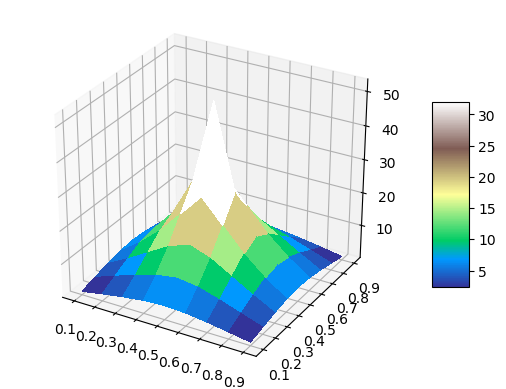

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')


X = np.linspace(0.1, 0.9, 9)
Y = np.linspace(0.1, 0.9, 9)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((9,9))

## iskoristimo dobiveno rješenje u1
j = 0
for i in range(9):
    Z[i][0:9] = u1[j:j+9]
    j = j + 9
    
surf = ax.plot_surface(X, Y, Z, cmap='terrain', linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
print('Rješenje problema')
plt.show()

<a id='asteroid'></a> 
### 3.3. Orbita asteroida


Pogledajmo i primjer kad predstavljene metode ne konvergiraju k rješenju. Keplerov prvi zakon kaže da orbita asteroida oko Sunca mora biti elipsa. Pogledajmo kako bi to izgledalo...



In [15]:
from matplotlib import animation
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from IPython.display import Video

mpl.rcParams.update(mpl.rcParamsDefault)

plt.style.use('dark_background')
fig = plt.figure(dpi=150)
fig.set_size_inches(5, 5)
ax = plt.axes(xlim=(-5, 5), ylim=(-3, 3))

elipsa = Ellipse(xy=(0,0), width=6, height=3, angle=45, edgecolor='y', fc='None', lw=2)
ax.add_patch(elipsa)

patch = Rectangle((0,0),0.3,0.3, fc='red', ec='red')

def init():
    ax.add_patch(patch)
    return [patch]

def animate(i):
    x = 3 * np.sin(np.radians(i))
    y = 1.5 * np.cos(np.radians(i))
    x1 = x*np.cos(-np.pi/4) + y*np.sin(-np.pi/4) 
    y1 = -x*np.sin(-np.pi/4) + y*np.cos(-np.pi/4)
    patch.xy=(x1-0.1,y1-0.1)
    return [patch]

ax.axis('off')
plt.title('ORBITA ASTEROIDA')
ax.axis('equal')

anim = animation.FuncAnimation(fig, animate, frames=1800, init_func=init, interval=25, blit=True)


# linija koju treba zakomentirati ako ne uspije instalacija: 
anim.save('orbita.mp4',writer='ffmpeg') 
  
plt.close(fig)
Video('orbita.mp4','mp4',embed=True)


Opća jednadžba ravninske konike dana je sa: $$Ax^2+Bxy+Cy^2+Dx+Ey+F=0$$
Astronom koji želi odrediti orbitu asteroida, postavlja koordinantni sustav u ravnini orbite sa središtem u suncu (fokus) i mjeri 5 različitih položaja asteroida u tom sustavu. Dakle, imamo 5 različitih točaka na orbiti pa je to dovoljno podataka da odredimo jednadžbu elipse po kojoj se kreće asteroid.

Jednadžba krivulje se ne mijenja ako je pomnožimo sa skalarom pa možemo uzeti da je $A=1$. Problem se onda svodi na: 

$$x^2+a_{1}xy+a_{2}y^2+a_{3}x+a_{4}y+a_{5}=0$$

Dakle, ako imamo izmjerene položaje, možemo doći do jednadžbe koja opisuje elipsu po kojoj se kreće asteroid. 

In [16]:
# izmjereni položaji -> vektor p
p = np.array([[2.7111,-4.1254],[3.7025,-3.7025],[4.1254,-2.7111],[3.8665,-1.4171],[2.99535,-0.16693]])
A = np.array([ [ p[0][0]*p[0][1],p[1][0]*p[1][1], p[2][0]*p[2][1], p[3][0]*p[3][1], p[4][0]*p[4][1] ], 
              [  p[0][1]**2,p[1][1]**2,p[2][1]**2,p[3][1]**2,p[4][1]**2  ], 
              [ p[0][0],p[1][0],p[2][0],p[3][0],p[4][0] ], 
              [ p[0][1],p[1][1],p[2][1],p[3][1],p[4][1] ], 
              np.ones(5) ])
A = np.transpose(A)
b = np.array([-p[0][0]**2,-p[1][0]**2,-p[2][0]**2,-p[3][0]**2,-p[4][0]**2])

x1, res1, info1 = jacobi(A,b)
x2, res2, info2 = sor(A,b)
x3, res3, info3 = sor(A,b, omega=1)
if info1==False:
    print('Jacobi ne konvergira k rješenju!')
if info2==False:
    print('SOR ne konvergira k rješenju!')
if info3==False:
    print('Gauss-Seidel ne konvergira k rješenju!')

Jacobi ne konvergira k rješenju!
SOR ne konvergira k rješenju!
Gauss-Seidel ne konvergira k rješenju!


Dakle, s nijednom od metoda nismo došli do rješenja. Pokušajmo ipak riješiti sustav s `scipy.linalg.solve()` da vidimo izgleda li rješenje kao elipsa.

In [17]:
x1 = la.solve(A,b)
print('Rješenje')
print(x1)

Rješenje
[ 0.76978682  1.00038529 -1.94339008  1.94602414 -2.46911068]


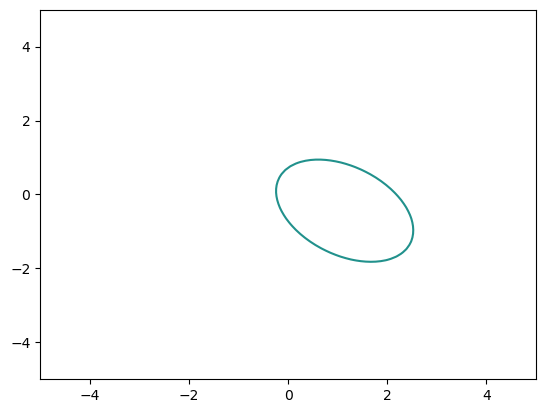

In [18]:
def f(x,y):
    return x**2+x1[0]*x*y+x1[1]*y**2+x1[2]*x+x1[3]+x1[4]
X = np.linspace(-5, 5, 100)
Y = X
X, Y = np.meshgrid(X, Y)
Z = f(X,Y)

mpl.rcParams.update(mpl.rcParamsDefault)

plt.contour(X,Y,Z,0)
plt.show()

<a id='zaključak'></a> 
## 4. Zaključak

Iako prethodne metode ne konvergiraju za svaku matricu sustava $A$, u primjerima 3.1 i 3.2 je pokazano kako korištenjem drugačijih algoritama možemo do rješenja doći u manje koraka. U cijelom eseju nisu spomenuti neki rezultati o konvergenciji ka rješenju za specifične matrice, tj. neki dovoljni uvjeti pa ih ovdje navodim, a za više informacija pogledati navedenu literaturu.

**Teorem 1**:

Neka je matrica sustava strogo dijagonalno dominantna ili ireducibilno dijagonlno dominantna. Tada su Jacobijeva i Gauss-Seidelova metoda konvergentne sa svakom početnom iteracijom $x_0$.

**Teorem 2 (konvergencija SOR metode)**

Ako je matrica sustava A simetrična pozitivno definitna matrica, tada SOR metoda konvergira za svaku početnu iteraciju $x^0$ i svaki $\omega\in(0,2)$. 

**Teorem**
Iteracije $x^{(k+1)}=Fx^{(k)}+c$ konvergiraju ka rješenju za svaki početni $x^0$ ako i samo ako je $spr(F)\leq1$. spr(F) je spektralni radijus matrice. 


Recimo, zadnja dva teorema su korištena kod računanja optimalnog $\omega$ u funkciji `sor_konvergencija`.

## Literatura
[1]. Predavanja kolegija [Znanstveno računanje 1](https://web.math.pmf.unizg.hr/~nela/zr1.html)

[2] Z.Drmač, Numerička analiza 1, [predavanja](https://web.math.pmf.unizg.hr/~drmac/na001.pdf)